# Walmart Recruiting - Store Sales Forecasting

## Importing the relevant libraries

In [86]:
# We will need the following libraries and modules
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import *
import seaborn as sns
import datetime 
import time
from time import gmtime, strftime
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor 
from sklearn.preprocessing import StandardScaler   
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split 
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import xgboost as xgb
sns.set()

## Loading source data

In [87]:
# Load the data from a .csv in the same folder
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
stores_df = pd.read_csv('stores.csv')
features_df = pd.read_csv('features.csv')

In [88]:
# Let's explore the top 5 rows of the data
print(train_df.head())
print(test_df.head())
print(stores_df.head())
print(features_df.head())

   Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False
   Store  Dept        Date  IsHoliday
0      1     1  2012-11-02      False
1      1     1  2012-11-09      False
2      1     1  2012-11-16      False
3      1     1  2012-11-23       True
4      1     1  2012-11-30      False
   Store Type    Size
0      1    A  151315
1      2    A  202307
2      3    B   37392
3      4    A  205863
4      5    B   34875
   Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05        42.31       2.572        NaN        NaN   
1      1  2010-02-12        38.51       2.548        NaN        NaN   
2      1  2010-02-19        39.93       2.514        NaN        NaN   
3      1  2010-02-26        46.63       2.56

## Preprocessing

In [89]:
trainall = pd.merge(train_df, stores_df, how='left', on=['Store'])
trainall = pd.merge(trainall, features_df, how='left', on=['Store','Date'])

testall = pd.merge(test_df, stores_df, how='left', on=['Store'])
testall = pd.merge(testall, features_df, how='left', on=['Store','Date'])

trainall.drop(columns=['IsHoliday_y'], axis=1, inplace=True)
testall.drop(columns=['IsHoliday_y'], axis=1, inplace=True)

trainall.rename(columns={'IsHoliday_x': 'IsHoliday'}, inplace=True)
testall.rename(columns={'IsHoliday_x': 'IsHoliday'}, inplace=True)


# Create Submission dataframe
submission = testall[['Store', 'Dept', 'Date']].copy()
submission['Id'] = submission['Store'].map(str) + '_' + submission['Dept'].map(str) + '_' + submission['Date'].map(str)
submission.drop(['Store', 'Dept', 'Date'], axis=1, inplace=True)

In [91]:
#check data type
pd.DataFrame(trainall.dtypes, columns=['Type'])

,Type
Store,int64
Dept,int64
Date,object
Weekly_Sales,float64
IsHoliday,bool
Type,object
Size,int64
Temperature,float64
Fuel_Price,float64
MarkDown1,float64


In [92]:
# Convert the Date column attribute from object to datetime column
trainall.Date = pd.to_datetime(trainall.Date)
testall.Date = pd.to_datetime(testall.Date)
#trainall.head()
pd.DataFrame(trainall.dtypes, columns=['Type'])

,Type
Store,int64
Dept,int64
Date,datetime64[ns]
Weekly_Sales,float64
IsHoliday,bool
Type,object
Size,int64
Temperature,float64
Fuel_Price,float64
MarkDown1,float64


### Dealing with missing values

In [93]:
# data.isnull() # shows a df with the information whether a data point is null 
# Since True = the data point is missing, while False = the data point is not missing, we can sum them
# This will give us the total number of missing values feature-wise
trainall.isnull().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Type                 0
Size                 0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
dtype: int64

In [94]:
#Lets convert all NaN value to '0' as simply droping all missing values is not always recommended
# Also make all value absolute because I am under the assumption that markdown are not negative values, as that will suggest 
#that the price of goods at walmart has been increased rather down marked down(reduction) e.g (+) values means reduction while
#(-) values will be addition in tis case.
trainall[['MarkDown1','MarkDown2','MarkDown3','MarkDown4', 'MarkDown5']] = trainall[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']].fillna(0)
testall[['MarkDown1','MarkDown2','MarkDown3','MarkDown4', 'MarkDown5']] = testall[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']].fillna(0)
trainall[['MarkDown1','MarkDown2','MarkDown3','MarkDown4', 'MarkDown5']] = abs(trainall[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']])
testall[['MarkDown1','MarkDown2','MarkDown3','MarkDown4', 'MarkDown5']] = abs(testall[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']])

# lets view if we have any null value in the dataset
trainall.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Type            0
Size            0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
dtype: int64

### Dealing with outliers

In [95]:
# Let's check the descriptives without 'Model'
trainall.describe(include='all')

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,421570.000000,421570.000000,421570,421570.000000,421570,421570,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
unique,NaN,NaN,143,NaN,2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,2011-12-23 00:00:00,NaN,False,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,3027,NaN,391909,215478,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,NaN,2010-02-05 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2012-10-26 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,22.200546,44.260317,NaN,15981.258123,NaN,NaN,136727.915739,60.090059,3.361027,2590.074819,880.166251,468.098193,1083.132268,1662.772385,171.201947,7.960289
std,12.785297,30.492054,NaN,22711.183519,NaN,NaN,60980.583328,18.447931,0.458515,6052.385934,5084.505576,5528.872561,3894.529945,4207.629321,39.159276,1.863296
min,1.000000,1.000000,NaN,-4988.940000,NaN,NaN,34875.000000,-2.060000,2.472000,0.000000,0.000000,0.000000,0.000000,0.000000,126.064000,3.879000
25%,11.000000,18.000000,NaN,2079.650000,NaN,NaN,93638.000000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000


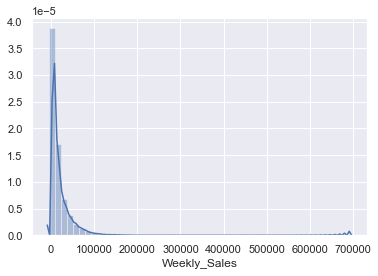

In [96]:
# A great step in the data exploration is to display the probability distribution function (PDF) of a variable
# The PDF will show us how that variable is distributed 
# This makes it very easy to spot anomalies, such as outliers
# The PDF is often the basis on which we decide whether we want to transform a feature
sns.distplot(trainall['Weekly_Sales'])

In [97]:
# Obviously there are some outliers present especially the negative value

# Outliers are a great issue for OLS, thus we must deal with them in some way
# It may be a useful exercise to try training a model without removing the outliers
# but in this case i will just simply remove the negative value as it will make little or no difference

# Then we can create a new df, with the condition that all weekly sales must be above or equal to 1 of 'weekly sales'
train_ = trainall[trainall['Weekly_Sales']>= 1]
# In this way we have essentially removed the less 0.5% of the data about 'weekly ales'
train_.describe(include='all')

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,419564.000000,419564.000000,419564,419564.000000,419564,419564,419564.000000,419564.000000,419564.000000,419564.000000,419564.000000,419564.000000,419564.000000,419564.000000,419564.000000,419564.000000
unique,NaN,NaN,143,NaN,2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,2011-11-25 00:00:00,NaN,False,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,3016,NaN,390028,214593,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,NaN,2010-02-05 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2012-10-26 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,22.193577,44.230353,NaN,16057.876531,NaN,NaN,136747.281578,60.074925,3.360749,2589.352582,880.170994,469.548841,1083.286504,1661.304132,171.204401,7.960345
std,12.786596,30.497080,NaN,22738.296157,NaN,NaN,60989.210629,18.449282,0.458551,6054.136336,5080.441862,5538.312107,3897.767850,4196.952056,39.160131,1.864053
min,1.000000,1.000000,NaN,1.000000,NaN,NaN,34875.000000,-2.060000,2.472000,0.000000,0.000000,0.000000,0.000000,0.000000,126.064000,3.879000
25%,11.000000,18.000000,NaN,2139.490000,NaN,NaN,93638.000000,46.670000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000


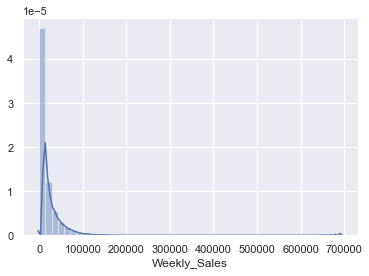

In [98]:
# We can check the PDF once again to ensure that the result is still distributed in the same way overall
# however, there are much fewer outliers
sns.distplot(train_['Weekly_Sales'])

### Correlation Plot to view Relationship

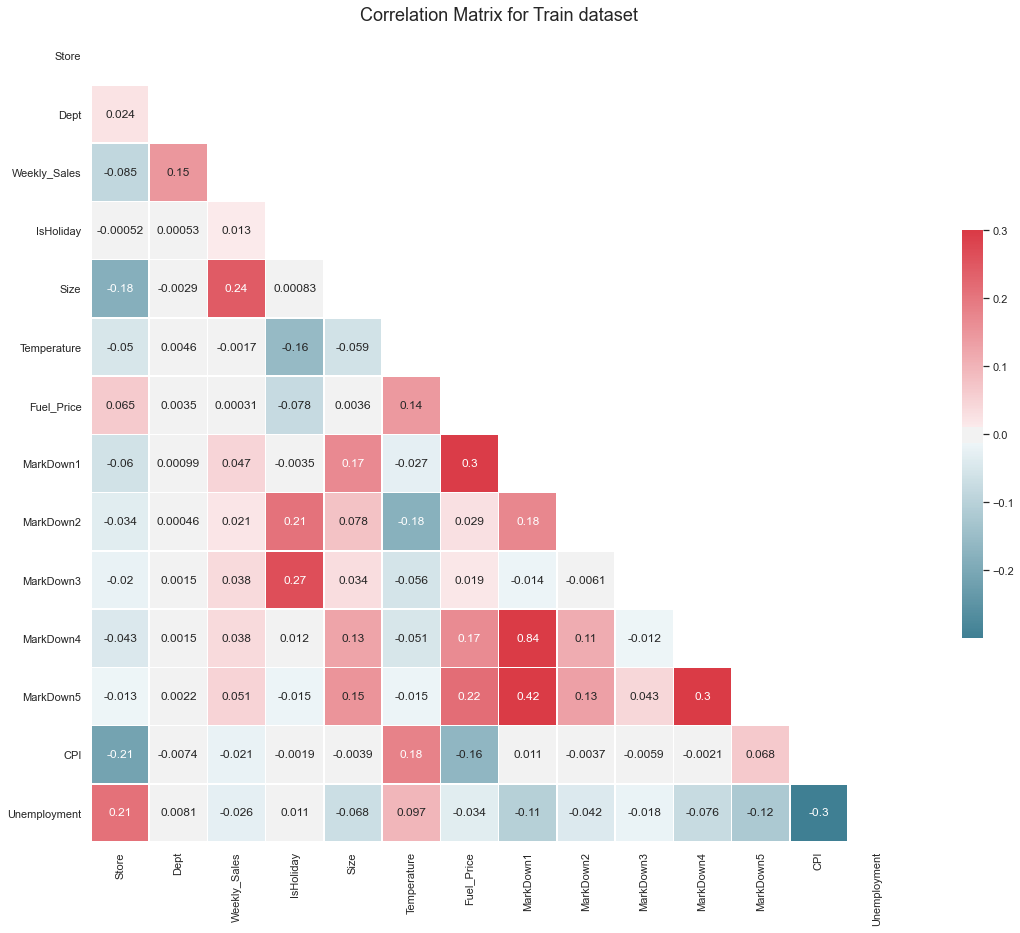

In [99]:
sns.set(style="white")
corr = train_.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(20, 15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.title('Correlation Matrix for Train dataset', fontsize=18)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.show()
#white, dark, whitegrid, darkgrid, ticks

In [100]:
train_.columns.values

array(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Type',
       'Size', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment'],
      dtype=object)

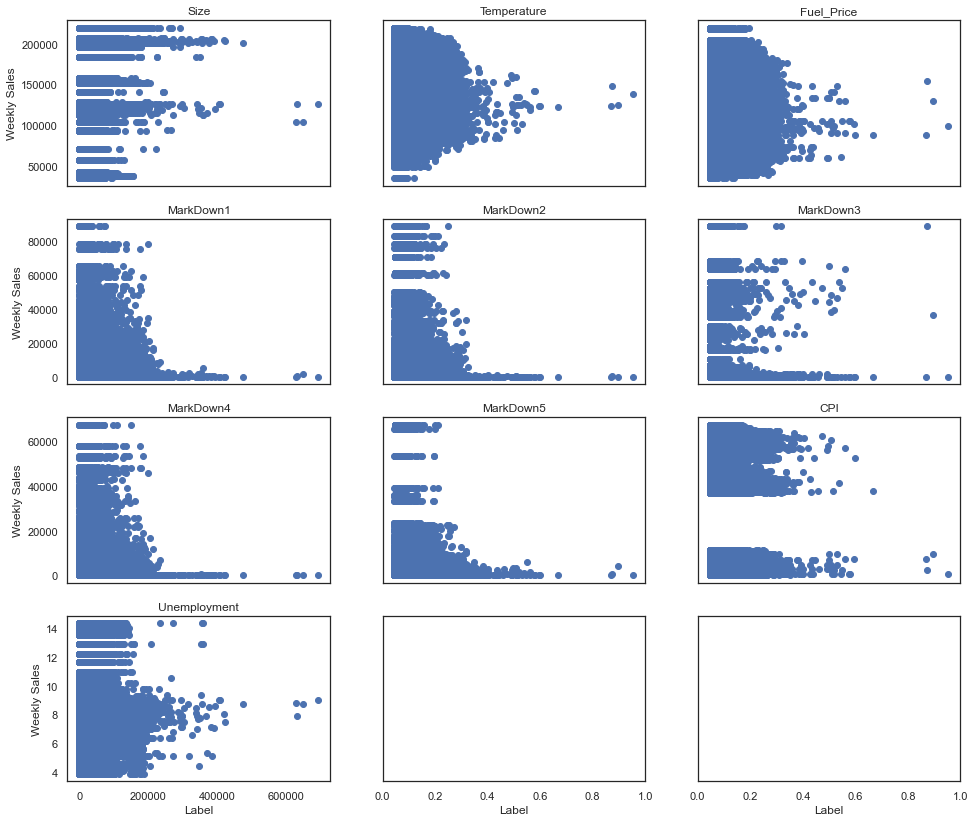

In [101]:
#Scatter plot of numeric columns vs weekly sales

fig, axs = plt.subplots(4, 3,figsize=(16,14))

axs[0, 0].scatter(train_.Weekly_Sales, train_.Size,)
axs[0, 0].set_title('Size')

axs[0, 1].scatter(train_.Weekly_Sales, train_.Temperature,)
axs[0, 1].set_title('Temperature')

axs[0, 2].scatter(train_.Weekly_Sales, train_.Fuel_Price,)
axs[0, 2].set_title('Fuel_Price')

axs[1, 0].scatter(train_.Weekly_Sales, train_.MarkDown1,)
axs[1, 0].set_title('MarkDown1')

axs[1, 1].scatter(train_.Weekly_Sales, train_.MarkDown2,)
axs[1, 1].set_title('MarkDown2')

axs[1, 2].scatter(train_.Weekly_Sales, train_.MarkDown3,)
axs[1, 2].set_title('MarkDown3')

axs[2, 0].scatter(train_.Weekly_Sales, train_.MarkDown4,)
axs[2, 0].set_title('MarkDown4')

axs[2, 1].scatter(train_.Weekly_Sales, train_.MarkDown5,)
axs[2, 1].set_title('MarkDown5')

axs[2, 2].scatter(train_.Weekly_Sales, train_.CPI,)
axs[2, 2].set_title('CPI')

axs[3, 0].scatter(train_.Weekly_Sales, train_.Unemployment,)
axs[3, 0].set_title('Unemployment')

for ax in axs.flat:
    ax.set(xlabel='Label', ylabel='Weekly Sales')
    

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

### Feature Engineering

In [102]:
#Get week from date for both train and test data
train_['Week'] = train_['Date'].dt.week
testall['Week'] = testall['Date'].dt.week
#convert Store and Department to string by adding a string value (S_, D_) to each variable 
train_['Store'] = 'S_' + train_['Store'].map(str)
train_['Dept'] = 'D_' + train_['Dept'].map(str)
testall['Store'] = 'S_' + testall['Store'].map(str)
testall['Dept'] = 'D_' + testall['Dept'].map(str)

C:\Users\stanl\anaconda3\envs\py3-TF2.0\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\stanl\anaconda3\envs\py3-TF2.0\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\stanl\anaconda3\envs\py3-TF2.0\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

In [103]:
# group the average departmental weekly sales value for each store

#select columns week,store,dept and weekly sales
trainallstore = train_[['Week','Store','Dept','Weekly_Sales']]
# group store and dept by average weekly sales
trainallstore = trainallstore.groupby(['Week','Store','Dept']).mean()

#remove index
trainallstore.reset_index(level=0, inplace=True)
trainallstore.reset_index(level=0, inplace=True)
trainallstore.reset_index(level=0, inplace=True)
trainallstore.rename(columns={'Weekly_Sales': 'SD_Sales'}, inplace=True)

In [104]:
#Now we merge the classK with the train and test data
trainall_N = train_.merge(trainallstore, how='left')
testall_N = testall.merge(trainallstore, how='left')

In [105]:
# add a check point to the data by copying
trainall = trainall_N.copy()
testall = testall_N.copy()

### One Hot Encoding

In [106]:
# Finally, once we reset the index, a new column will be created containing the old index (just in case)
# We won't be needing it, thus 'drop=True' to completely forget about it
train_ = trainall.reset_index(drop=True)
test_ = testall.reset_index(drop=True)

In [107]:
# dropping irrelevant columns since we will be creating dummies
train_some = train_.drop(columns=['Store','Dept','Date','Type','IsHoliday'])
#creating dummies for 5 column
dept_dummies = pd.get_dummies(train_['Dept'])
type_dummies = pd.get_dummies(train_['Type'])
store_dummies = pd.get_dummies(train_['Store'])
#n_dummies = pd.get_dummies(train_['storedept'])
holiday_dummies = pd.get_dummies(train_['IsHoliday'])
#merging all 5 dummies to main train data
#train_unscale = pd.concat([train_some,type_dummies,store_dummies,dept_dummies, holiday_dummies,n_dummies],axis=1)
train_unscale = pd.concat([train_some,type_dummies,store_dummies,dept_dummies, holiday_dummies],axis=1)


#Repeat the same for test data
test_some = test_.drop(columns=['Type','IsHoliday'])
dept_dummies2 = pd.get_dummies(test_['Dept'])
type_dummies2 = pd.get_dummies(test_['Type'])
store_dummies2 = pd.get_dummies(test_['Store'])
#n_dummies2 = pd.get_dummies(test_['storedept'])
holiday_dummies2 = pd.get_dummies(test_['IsHoliday'])

#test_ = pd.concat([test_some,type_dummies2,n_dummies2,store_dummies2,dept_dummies2,holiday_dummies2],axis=1)
test_ = pd.concat([test_some,type_dummies2,store_dummies2,dept_dummies2,holiday_dummies2],axis=1)
test_unscale = test_.drop(columns=['Store','Dept','Date'])
#fill NaN values with previous
test_unscale.fillna(method='ffill', inplace=True)

### Quick Correlation

In [108]:
# sorted values of correlation
train_unscale.corr()['Weekly_Sales'].sort_values()


B              -0.131255
C              -0.095689
D_28           -0.082471
D_59           -0.081744
D_60           -0.081550
                  ...   
D_38            0.247174
D_95            0.295112
D_92            0.324643
SD_Sales        0.994019
Weekly_Sales    1.000000
Name: Weekly_Sales, Length: 144, dtype: float64

### Log Transformation

In [109]:
#train_unscale = train_unscale.reset_index()
#test_unscale = test_unscale.reset_index()

# Let's transform 'weekly_sales' with a log transformation
train_unscale['log_price'] = np.log(train_unscale['Weekly_Sales'])
#train_unscale['log_price'] = train_unscale['Weekly_Sales']
# Then we add it to our data frame
train_logprice = train_unscale.drop(['Weekly_Sales'],axis=1)
# Let's quickly see the columns of our data frame
train_logprice.columns.values
train_unscale.isnull().sum()

Weekly_Sales    0
Size            0
Temperature     0
Fuel_Price      0
MarkDown1       0
               ..
D_98            0
D_99            0
False           0
True            0
log_price       0
Length: 145, dtype: int64

### Declare the inputs and the targets

In [110]:
# The target(s) (dependent variable) is 'log price'
targets = train_logprice['log_price']

# The inputs are everything BUT the dependent variable, so we can simply drop it
inputs = train_logprice.drop(['log_price'],axis=1)

### Scale the data

In [111]:
# Create a scaler object
scaler = StandardScaler()
# Fit the inputs (calculate the mean and standard deviation feature-wise)
scaler.fit(inputs)


StandardScaler(copy=True, with_mean=True, with_std=True)

In [112]:
inputs_scaled = scaler.transform(inputs)

### Train Test Split

In [113]:
#This is for the initial testing, once a model is selected, the xtrain will be inputs_scaled and the ytrain will be targets
# Split the variables with an 75-25 split and some random state
# To have the same split as mine, use random_state = 365
x_train, x_test, y_train, y_test = train_test_split(inputs_scaled, targets, test_size=0.25, random_state=365)

## Linear regression model

### Create the regression

In [114]:
# Lets try linear regression for fun
# Create a linear regression object
reg = LinearRegression()
# Fit the regression with the scaled TRAIN inputs and targets
reg.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [115]:
# Let's check the outputs of the regression
# I'll store them in y_hat
y_hat = reg.predict(x_train)

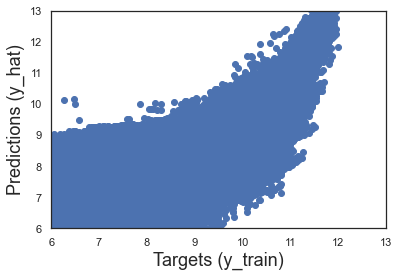

In [116]:
# The simplest way to compare the targets (y_train) and the predictions (y_hat) is to plot them on a scatter plot
# The closer the points to the 45-degree line, the better the prediction
plt.scatter(y_train, y_hat)
# Let's also name the axes
plt.xlabel('Targets (y_train)',size=18)
plt.ylabel('Predictions (y_hat)',size=18)
# Sometimes the plot will have different scales of the x-axis and the y-axis
# This is an issue as we won't be able to interpret the '45-degree line'
# We want the x-axis and the y-axis to be the same
plt.xlim(6,13)
plt.ylim(6,13)
plt.show()

In [117]:
# Find the R-squared of the model
reg.score(x_train,y_train)

# Note that this is NOT the adjusted R-squared


0.7229108330554441

### Finding the weights and bias

In [118]:
# Obtain the bias (intercept) of the regression
reg.intercept_
# We can obtain the weights (coefficients) of the regression, but there is no need as I are not going to use thi model
# to check coefficient use reg.coef_

8.53516339462907

## Testing Regression

In [119]:
y_hat_test = reg.predict(x_test)

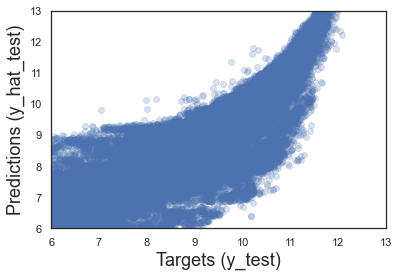

In [120]:
# To Create a scatter plot with the test targets and the test predictions
plt.scatter(y_test, y_hat_test, alpha=0.2)
plt.xlabel('Targets (y_test)',size=18)
plt.ylabel('Predictions (y_hat_test)',size=18)
plt.xlim(6,13)
plt.ylim(6,13)
plt.show()

In [121]:
# Finally, let's manually check these predictions
# To obtain the actual prices, we take the exponential of the log_price
df_pf = pd.DataFrame(np.exp(y_hat_test), columns=['Prediction'])
df_pf.head()

,Prediction
0,26446.218858
1,3899.813079
2,63487.663767
3,477.219186
4,12046.778452


In [122]:
# After displaying y_test, we find what the issue is
# The old indexes are preserved (recall earlier in that code we made a note on that)
# The code was: data_cleaned = data_4.reset_index(drop=True)

# Therefore, to get a proper result, we must reset the index and drop the old indexing
y_test = y_test.reset_index(drop=True)

# Let's overwrite the 'Target' column with the appropriate values
# Again, we need the exponential of the test log price
df_pf['Target'] = np.exp(y_test)
df_pf
# Find the R-squared of the model


,Prediction,Target
0,26446.218858,42530.63
1,3899.813079,4198.56
2,63487.663767,56084.02
3,477.219186,73.48
4,12046.778452,12137.27
...,...,...
104886,18560.733599,29627.06
104887,1167.083294,56.00
104888,3743.552657,7185.32
104889,53247.044214,40054.65


# New Work on Grid serach for Random Forest

In [123]:
''''#This will take too long, so dont run
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [2, 4],
    'n_estimators': [50,80, 150]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(x_train, y_train)
grid_search.best_params_
'''

"'#This will take too long, so dont run\n# Create the parameter grid based on the results of random search \nparam_grid = {\n    'bootstrap': [True],\n    'min_samples_leaf': [1, 2],\n    'min_samples_split': [2, 4],\n    'n_estimators': [50,80, 150]\n}\n# Create a based model\nrf = RandomForestRegressor()\n# Instantiate the grid search model\ngrid_search = GridSearchCV(estimator = rf, param_grid = param_grid, \n                          cv = 3, n_jobs = -1, verbose = 2)\n\ngrid_search.fit(x_train, y_train)\ngrid_search.best_params_\n"

# Random Forest

In [124]:
#Random forest model specification

regr = RandomForestRegressor(n_estimators=20, criterion='mse', max_depth=None, 
                      min_samples_split=2, min_samples_leaf=1, 
                      min_weight_fraction_leaf=0.0, max_features='auto', 
                      max_leaf_nodes=None, min_impurity_decrease=0.0, 
                      min_impurity_split=None, bootstrap=True, 
                      oob_score=False, n_jobs=1, random_state=None, 
                      verbose=2, warm_start=False)

#Train on data
regr.fit(x_train, y_train.ravel())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 20


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.6s remaining:    0.0s


building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  2.6min finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=20, n_jobs=1, oob_score=False,
                      random_state=None, verbose=2, warm_start=False)

In [125]:
##Model evaluation
##To evaluate the model, we will look at MAE and accuracy in terms of the number of times it
##correctly estimated an upward or downward deviation from the median.
y_pred = regr.predict(x_train)
trainzz = y_train.to_frame()
trainzz['Predicted'] = y_pred


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    2.6s finished


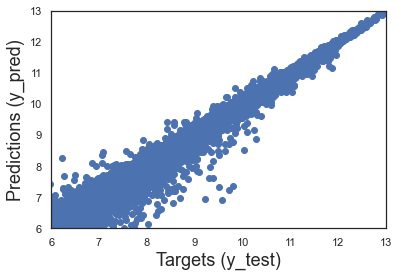

In [126]:
#quick plot of targets and prediction
plt.scatter(trainzz.log_price, trainzz.Predicted)
# Let's also name the axes
plt.xlabel('Targets (y_test)',size=18)
plt.ylabel('Predictions (y_pred)',size=18)
# We want the x-axis and the y-axis to be the same
plt.xlim(6,13)
plt.ylim(6,13)
plt.show()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.8s finished


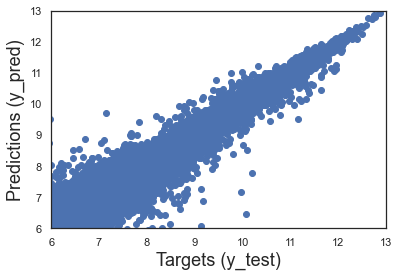

In [127]:
y_predt = regr.predict(x_test)
testzz = y_test.to_frame()
testzz['Predicted'] = y_predt
plt.scatter(testzz.log_price, testzz.Predicted)
# Let's also name the axes
plt.xlabel('Targets (y_test)',size=18)
plt.ylabel('Predictions (y_pred)',size=18)
# Sometimes the plot will have different scales of the x-axis and the y-axis
# This is an issue as we won't be able to interpret the '45-degree line'
# We want the x-axis and the y-axis to be the same
plt.xlim(6,13)
plt.ylim(6,13)
plt.show()

In [128]:
trainr2 = r2_score(y_train , y_pred)
trainmae = mean_squared_error(y_train , y_pred)
testmae = mean_squared_error(y_test , y_predt)
testr2 = r2_score(y_test, y_predt)
print('The train score r2= ',trainr2, 'and mae =', trainmae)
print('The test score r2 = ',testr2,'and mae = ', testmae)

The train score r2=  0.9964571507002057 and mae = 0.014298431332910115
The test score r2 =  0.9781519983680331 and mae =  0.0887026257276137


## Xgboost Parameter Grid search

In [129]:
'''
xgb_reg = xgb.XGBRegressor(n_estimators=50)

# Parameters to Grid search
tuned_parameters = [{'learning_rate':[0.1],'max_depth':[3,4,5,10]}]

# Grid search

xgb_gs = GridSearchCV(estimator=xgb_reg, param_grid=tuned_parameters, scoring= 'r2', cv=5, n_jobs=10)
xgb_gs.fit(x_train,y_train)
print('The best parameters for XGBoost Regression is: ',xgb_gs.best_params_)
'''

"\nxgb_reg = xgb.XGBRegressor(n_estimators=50)\n\n# Parameters to Grid search\ntuned_parameters = [{'learning_rate':[0.1],'max_depth':[3,4,5,10]}]\n\n# Grid search\n\nxgb_gs = GridSearchCV(estimator=xgb_reg, param_grid=tuned_parameters, scoring= 'r2', cv=5, n_jobs=10)\nxgb_gs.fit(x_train,y_train)\nprint('The best parameters for XGBoost Regression is: ',xgb_gs.best_params_)\n"

## Train xgboost with best parameter

In [130]:

xgbr = xgb.XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=None, max_depth=10,
             min_child_weight=None, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             objective='reg:squarederror', random_state=None, reg_alpha=None,
             reg_lambda=None, scale_pos_weight=None, subsample=None,
             tree_method=None, validate_parameters=None, verbosity=0)

xgbr.fit(x_train, y_train)

score = xgbr.score(x_train, y_train)   
print("Training score: ", score) 

Training score:  0.9924464326927424


The train score r2 =  0.9924464326927424 and mae =  0.03048511362524209
The test score r2 =  0.9838517601359706  and mae =  0.0655616610135608


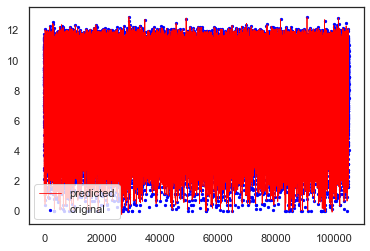

In [131]:
y_predxgb = xgbr.predict(x_train)
y_predxgbt = xgbr.predict(x_test)

xtrainr2 = r2_score(y_train , y_predxgb)
xtrainmae = mean_squared_error(y_train , y_predxgb)
xtestmae = mean_squared_error(y_test , y_predxgbt)
xtestr2 = r2_score(y_test, y_predxgbt)
print('The train score r2 = ',xtrainr2,'and mae = ', xtrainmae)
print('The test score r2 = ',xtestr2, ' and mae = ',xtestmae)

x_ax = range(len(y_test))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.plot(x_ax, y_predxgbt, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()


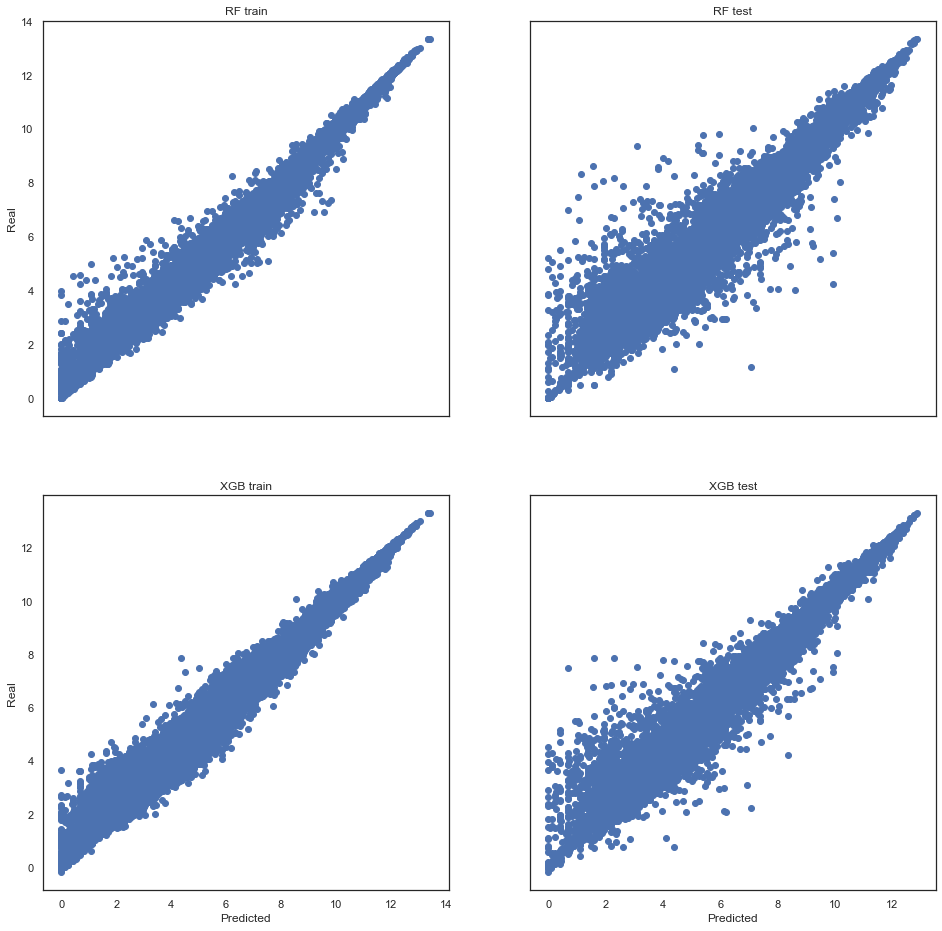

In [132]:
trainzz['Predictedxgb'] = y_predxgb
testzz['Predictedxgb'] = y_predxgbt

fig, axs = plt.subplots(2, 2,figsize=(16,16))

axs[0, 0].scatter(trainzz.log_price, trainzz.Predicted,)
axs[0, 0].set_title('RF train')

axs[0, 1].scatter(testzz.log_price, testzz.Predicted,)
axs[0, 1].set_title('RF test')

axs[1, 0].scatter(trainzz.log_price, trainzz.Predictedxgb,)
axs[1, 0].set_title('XGB train')

axs[1, 1].scatter(testzz.log_price, testzz.Predictedxgb,)
axs[1, 1].set_title('XGB test')


for ax in axs.flat:
    ax.set(xlabel='Predicted', ylabel='Real')
    

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [133]:
## Train data using xgboost for all train dataset provided by walmart

In [134]:

xgbfinal = xgb.XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=None, max_depth=10,
             min_child_weight=None, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             objective='reg:squarederror', random_state=None, reg_alpha=None,
             reg_lambda=None, scale_pos_weight=None, subsample=None,
             tree_method=None, validate_parameters=None, verbosity=0)
xgbfinal.fit(inputs_scaled, targets)

score = xgbfinal.score(inputs_scaled, targets)  
print("Training score: ", score) 

Training score:  0.992013597789589


In [135]:
RF = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=20, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=2, warm_start=False)
RF.fit(inputs_scaled, targets)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20building tree 7 of 20
building tree 8 of 20
building tree 9 of 20

building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:   20.7s remaining:   31.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   37.0s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=20, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=2, warm_start=False)

In [136]:
#process test data by scaling it using the same scaler defined earlier
scaler = StandardScaler()
scaler.fit(test_unscale)

# The target(s) (dependent variable) is 'log price'

StandardScaler(copy=True, with_mean=True, with_std=True)

In [137]:
test_scaled = scaler.transform(test_unscale)

In [138]:
#At final, we can predict the test!
y_pred = xgbfinal.predict(test_scaled)

y_pred2 = RF.predict(test_scaled)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  20 out of  20 | elapsed:    0.0s finished


In [139]:
reg.fit(inputs_scaled, targets)
y_pred3 = reg.predict(test_scaled)

In [140]:

# Menaging final_df to have competition rules standard
testdataframe = test_[['Store','Dept','Date']]
testdataframe['Id'] = testdataframe['Store'].astype(str) + '_' + testdataframe['Dept'].astype(str) + '_' + testdataframe['Date'].astype(str)
testdataframe.drop(columns=['Store','Dept','Date'],inplace=True)

# Therefore, to get a proper result, we must reset the index and drop the old indexing
testdataframe['Id'].reset_index(drop=True)
testdataframe['Weekly_Sales'] = np.exp(y_pred)




C:\Users\stanl\anaconda3\envs\py3-TF2.0\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\stanl\anaconda3\envs\py3-TF2.0\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\stanl\anaconda3\envs\py3-TF2.0\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [141]:
testdataframe['Id']  = testdataframe.replace(regex=['S_'], value='')
testdataframe['Id']  = testdataframe.replace(regex=['D_'], value='')
testdataframe.head(50)

C:\Users\stanl\anaconda3\envs\py3-TF2.0\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\stanl\anaconda3\envs\py3-TF2.0\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Id,Weekly_Sales
0,1_1_2012-11-02,34691.015625
1,1_1_2012-11-09,18761.253906
2,1_1_2012-11-16,18372.673828
3,1_1_2012-11-23,19063.353516
4,1_1_2012-11-30,22958.572266
5,1_1_2012-12-07,31817.208984
6,1_1_2012-12-14,42726.507812
7,1_1_2012-12-21,45559.316406
8,1_1_2012-12-28,20489.125000
9,1_1_2013-01-04,16306.948242


In [2]:
testdataframe.to_csv('submission.csv', index=False)
